# Projeto 2 - Ciência dos Dados 2020.2

**Participantes**

- Enrico Lopez Borges de Carvalho

- Luana Mitsudo Coelho

- Luiza Valezim Augusto Pinto

- Rodrigo Carvalho Monteiro de Barros

## Introdução

Esse Projeto tem como objetivo tentar prever a nota que diversos jogos receberiam no site *Metacritic*, um site de avaliação de jogos. Para isso, foram levadas em consideração suas características principais (como seu preço, seu gênero, entre outros), informações obtidas em um datasheet do site *Kaggle* em forma de Excel. <br>
Foram selecionadas somente àquelas colunas de características que interessavam para o resultado da previsão.  <br>
O método utilizado foi **INSERIR O NOME DO MÉTODO QUE IREMOS UTILIZAR**, o qual (...)

## Desenvolvimento

**Carregando as bibliotecas**

In [43]:

pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [80]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image
#biblioteca de decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from scipy.stats import linregress
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.tree import export_graphviz
import pydot
from graphviz import render
import datetime

**Carregando a base de dados dos jogos**

In [45]:
filename = 'Games.xlsx'
if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo para prosseguir com o projeto!')
else:
    print(f'Não encontrei o arquivo {filename} aqui no diretório {os.getcwd()} :(')

Encontrei o arquivo Games.xlsx, tudo certo para prosseguir com o projeto!


 # Lendo os arquivos

In [46]:
#cria o dataframe a partir da tabela excel
games =  pd.read_excel(filename)

# Formatando Datasheet para trabalhar.

Algumas colunas do Datasheet obtido não estavam em um formato favorável para a manupilação em pandas, portanto, foram necessarias algumas alterações. Colunas com informações não importantes para a previsão desejada foram descartadas. Algumas colunas precisaram ser manipuladas quanto a valores numericos ou categorias, mais simples de manipular com o Pandas e com o Sklearn. 

In [47]:
#retira colunas não desejadas do dataframe
jogos = games.drop('Column1',axis=1).drop('id',axis=1).drop('RawgID',axis=1).drop('SteamURL',axis=1).drop('Graphics',axis=1) \
            .drop('Storage',axis=1).drop('Memory',axis=1).drop('RatingsBreakdown',axis=1).drop('ReleaseDate',axis=1)\
            .drop('Soundtrack',axis=1).drop('Franchise',axis=1).drop('DiscountedCost',axis=1).drop('Controller',axis=1)\
            .drop('ESRB',axis=1).drop('Publisher',axis=1).drop('Description',axis=1).drop('Tags',axis=1).copy()

#retira linhas com dados faltando do dataframe.
jogos = jogos.dropna()
jogos = jogos.reset_index(drop=True) # correção necessaria para reorganizar as

jogos

Name  Metacritic  \
0      Counter-Strike: Global Offensive       830.0   
1                             Destiny 2       820.0   
2              The Elder Scrolls Online       710.0   
3                        Sea of Thieves       680.0   
4        Tom Clancy's Rainbow Six Siege       750.0   
...                                 ...         ...   
2330              Metroid: Zero Mission       890.0   
2331             Crookz - The Big Heist       740.0   
2332  NARUTO TO BORUTO: SHINOBI STRIKER       620.0   
2333           The Fall Part 2: Unbound       720.0   
2334                            FIFA 20       680.0   

                                                Genres  Indie    Presence  \
0                                 Action, Free to Play    0.0  10095880.0   
1                      Action, Adventure, Free to Play    0.0  10074250.0   
2                           Massively Multiplayer, RPG    0.0  10007810.0   
3                                    Action, Adventure    0.0   7774560.0   
4                                               Action    0.0  10014240.0   
...                                                ...    ...         ...   
2330                       Action, Indie, Early Access   10.0   5485350.0   
2331                          Adventure, Casual, Indie   10.0     29260.0   
2332                                            Action    0.0   1651550.0   
2333  Action, Casual, Indie, RPG, Simulation, Strategy   10.0    114980.0   
2334                                   Indie, Strategy   10.0  10007360.0   

                                               Platform  OriginalCost  \
0                           PC, Xbox 360, PlayStation 3  Free to Play   
1     PlayStation 5, Web, Xbox Series X, PC, Xbox On...  Free To Play   
2                                                    PC        $19.99   
3                                          PC, Xbox One        $39.99   
4                           PlayStation 4, PC, Xbox One        $19.99   
...                                                 ...           ...   
2330                            Game Boy Advance, Wii U         $1.99   
2331                              macOS, iOS, Linux, PC         $3.99   
2332                        PC, Xbox One, PlayStation 4         $2.99   
2333  PC, macOS, Linux, PlayStation 4, Xbox One, Nin...         $0.99   
2334       Nintendo Switch, PlayStation 4, Xbox One, PC         $4.99   

                                           Players  \
0              multiplayer, pvp, coop, online coop   
1                   multiplayer, coop, online coop   
2                  singleplayer, multiplayer, coop   
3              multiplayer, pvp, coop, online coop   
4     singleplayer, multiplayer, coop, online coop   
...                                            ...   
2330                                  singleplayer   
2331                                  singleplayer   
2332                                  singleplayer   
2333                                  singleplayer   
2334                                  singleplayer   

                                              Languages  Achievements  
0     English, Czech, Danish, Dutch, Finnish, French...        1790.0  
1     English, French, Italian, German, Japanese, Ko...         610.0  
2                      English, French, German, Russian           0.0  
3             English, French, Italian, German, Russian        3080.0  
4     English, French, Italian, German, Czech, Dutch...         820.0  
...                                                 ...           ...  
2330                                            English           0.0  
2331                                            English         300.0  
2332                                            English         480.0  
2333                                   English, Russian         750.0  
2334                                            English         630.0  

[2335 rows x 10 columns]

### Mudanças na coluna "Languages"
A coluna apresentava, para cada jogo, uma lista de linguas em que o mesmo era disponibilizado. O código abaixo lê cada linha dessa coluna e substitui a lista em texto pelo numero de linguas disponiveis.

In [48]:
#transforma a coluna "Laguages" de uma lista de linguas para uma quantidade de linguas disponiveis
for L in range(len(jogos.Languages)):
    lista_linguas = str(jogos.Languages[L]).split(",")
    jogos.Languages[L] = len(lista_linguas)


C:\Users\enric\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Mudanças na coluna "OriginalCost"

In [49]:
#transforma os textos da coluna "OriginalCost" em valores escritos
jogos.OriginalCost = jogos.OriginalCost.str.extract('(\d+)').astype(float).fillna(0)

        #jogos.OriginalCost[P] = 0
#if jogos.OriginalCost[P].contains("$") :
#jogos.OriginalCost.dtype
#jogos.OriginalCost.unique()
#jogos.OriginalCost[2]
jogos

Name  Metacritic  \
0      Counter-Strike: Global Offensive       830.0   
1                             Destiny 2       820.0   
2              The Elder Scrolls Online       710.0   
3                        Sea of Thieves       680.0   
4        Tom Clancy's Rainbow Six Siege       750.0   
...                                 ...         ...   
2330              Metroid: Zero Mission       890.0   
2331             Crookz - The Big Heist       740.0   
2332  NARUTO TO BORUTO: SHINOBI STRIKER       620.0   
2333           The Fall Part 2: Unbound       720.0   
2334                            FIFA 20       680.0   

                                                Genres  Indie    Presence  \
0                                 Action, Free to Play    0.0  10095880.0   
1                      Action, Adventure, Free to Play    0.0  10074250.0   
2                           Massively Multiplayer, RPG    0.0  10007810.0   
3                                    Action, Adventure    0.0   7774560.0   
4                                               Action    0.0  10014240.0   
...                                                ...    ...         ...   
2330                       Action, Indie, Early Access   10.0   5485350.0   
2331                          Adventure, Casual, Indie   10.0     29260.0   
2332                                            Action    0.0   1651550.0   
2333  Action, Casual, Indie, RPG, Simulation, Strategy   10.0    114980.0   
2334                                   Indie, Strategy   10.0  10007360.0   

                                               Platform  OriginalCost  \
0                           PC, Xbox 360, PlayStation 3           0.0   
1     PlayStation 5, Web, Xbox Series X, PC, Xbox On...           0.0   
2                                                    PC          19.0   
3                                          PC, Xbox One          39.0   
4                           PlayStation 4, PC, Xbox One          19.0   
...                                                 ...           ...   
2330                            Game Boy Advance, Wii U           1.0   
2331                              macOS, iOS, Linux, PC           3.0   
2332                        PC, Xbox One, PlayStation 4           2.0   
2333  PC, macOS, Linux, PlayStation 4, Xbox One, Nin...           0.0   
2334       Nintendo Switch, PlayStation 4, Xbox One, PC           4.0   

                                           Players Languages  Achievements  
0              multiplayer, pvp, coop, online coop        23        1790.0  
1                   multiplayer, coop, online coop         8         610.0  
2                  singleplayer, multiplayer, coop         4           0.0  
3              multiplayer, pvp, coop, online coop         5        3080.0  
4     singleplayer, multiplayer, coop, online coop        12         820.0  
...                                            ...       ...           ...  
2330                                  singleplayer         1           0.0  
2331                                  singleplayer         1         300.0  
2332                                  singleplayer         1         480.0  
2333                                  singleplayer         2         750.0  
2334                                  singleplayer         1         630.0  

[2335 rows x 10 columns]

### Dividindo as colunas "Players", "Genders" e "Platform" e criando novas colunas
As colunas "Players", "Genders" e "Platform" apresentavam uma lista de modos de jogo em que o mesmo era disponibilizado, os generos nos quais o jogo se encaixa e as plataformas em que ele está disponivel, respectivamente. 
O código abaixo lê cada uma dessas colunas, e cria uma coluna, com valores boleanos, para cada opção das categorias de cada coluna.

In [50]:
#Genres
textog=",".join(jogos.Genres)
textog=textog.split(",")
lista_gen=[]
for el in textog:
    if el not in lista_gen and el[0]!=" ":
        lista_gen.append(el)
print(lista_gen)

for elem in lista_gen:
    filtrod=jogos.Genres.str.contains(f"{elem}")
    jogos.loc[filtrod,f"{elem}"]=filtrod

['Action', 'Massively Multiplayer', 'Strategy', 'Racing', 'RPG', 'Simulation', 'Casual', 'Adventure', 'Indie', 'Free to Play', 'Sports']


In [51]:
#Platform
textplat=",".join(jogos.Platform)
textplat=textplat.split(",")
lista_plat=[]
for el in textplat:
    if el not in lista_plat and el[0]!=" ":
        lista_plat.append(el)
print(lista_plat)

for ele in lista_plat:
    filtrodd=jogos.Platform.str.contains(f"{ele}")
    jogos.loc[filtrodd,f"{ele}"]=filtrodd

['PC', 'PlayStation 5', 'PlayStation 4', 'Linux', 'Xbox One', 'Xbox Series X', 'macOS', 'Android', 'iOS', 'Nintendo Switch', 'PlayStation 3', 'Xbox 360', 'Nintendo 3DS', 'GameCube', 'SNES', 'PS Vita', 'Nintendo DS', 'PlayStation 2', 'Xbox', 'Dreamcast', 'Wii', 'PlayStation', 'Web', 'Wii U', 'Game Boy Advance']


In [52]:
#Players
textplayers=",".join(jogos.Players)
textplayers=textplayers.split(",")
lista_players=[]
for el in textplayers:
    if el not in lista_players and el[0]!=" ":
        lista_players.append(el)
print(lista_players)

for ele in lista_players:
    filtroddd=jogos.Players.str.contains(f"{ele}")
    jogos.loc[filtroddd,f"{ele}"]=filtroddd

['multiplayer', 'singleplayer', 'coop', 'pvp', 'online coop']


In [53]:
del jogos["Players"]
del jogos["Genres"]
del jogos["Platform"]

jogos

Name  Metacritic Indie    Presence  \
0      Counter-Strike: Global Offensive       830.0     0  10095880.0   
1                             Destiny 2       820.0     0  10074250.0   
2              The Elder Scrolls Online       710.0     0  10007810.0   
3                        Sea of Thieves       680.0     0   7774560.0   
4        Tom Clancy's Rainbow Six Siege       750.0     0  10014240.0   
...                                 ...         ...   ...         ...   
2330              Metroid: Zero Mission       890.0  True   5485350.0   
2331             Crookz - The Big Heist       740.0  True     29260.0   
2332  NARUTO TO BORUTO: SHINOBI STRIKER       620.0     0   1651550.0   
2333           The Fall Part 2: Unbound       720.0  True    114980.0   
2334                            FIFA 20       680.0  True  10007360.0   

      OriginalCost Languages  Achievements Action Massively Multiplayer  \
0              0.0        23        1790.0   True                   NaN   
1              0.0         8         610.0   True                   NaN   
2             19.0         4           0.0    NaN                  True   
3             39.0         5        3080.0   True                   NaN   
4             19.0        12         820.0   True                   NaN   
...            ...       ...           ...    ...                   ...   
2330           1.0         1           0.0   True                   NaN   
2331           3.0         1         300.0    NaN                   NaN   
2332           2.0         1         480.0   True                   NaN   
2333           0.0         2         750.0   True                   NaN   
2334           4.0         1         630.0    NaN                   NaN   

     Strategy  ...   Wii PlayStation   Web Wii U Game Boy Advance multiplayer  \
0         NaN  ...   NaN        True   NaN   NaN              NaN        True   
1         NaN  ...   NaN        True  True   NaN              NaN        True   
2         NaN  ...   NaN         NaN   NaN   NaN              NaN        True   
3         NaN  ...   NaN         NaN   NaN   NaN              NaN        True   
4         NaN  ...   NaN        True   NaN   NaN              NaN        True   
...       ...  ...   ...         ...   ...   ...              ...         ...   
2330      NaN  ...  True         NaN   NaN  True             True         NaN   
2331      NaN  ...   NaN         NaN   NaN   NaN              NaN         NaN   
2332      NaN  ...   NaN        True   NaN   NaN              NaN         NaN   
2333     True  ...   NaN        True   NaN   NaN              NaN         NaN   
2334     True  ...   NaN        True   NaN   NaN              NaN         NaN   

     singleplayer  coop   pvp online coop  
0             NaN  True  True        True  
1             NaN  True   NaN        True  
2            True  True   NaN         NaN  
3             NaN  True  True        True  
4            True  True   NaN        True  
...           ...   ...   ...         ...  
2330         True   NaN   NaN         NaN  
2331         True   NaN   NaN         NaN  
2332         True   NaN   NaN         NaN  
2333         True   NaN   NaN         NaN  
2334         True   NaN   NaN         NaN  

[2335 rows x 47 columns]

### Descrição das variaveis da tabela final:
 
 **Name:** Nome do jogo.
 
 **Metacritic:** Nota dada pelo site Metacritic até 1000 pontos, sendo, quanto maior, melhor.
 
 **Genres:** Gêneros em que o jogo pode ser classificado.
 
 **Indie:** Se o jogo se classifica como Indie ou não (0 significa que não e 10 significa que sim).
 
 **Presence:** Quantas vezes foi mencionado nas redes sociais (pode ser lido também como relevância).
 
 **Platform:** Plataformas disponíveis do jogo.
 
 **OriginalCost:** Preço (em dólares americanos) do jogo na data de lançamento.
 
 **Players:** Modos de jogo disponíveis para o jogo ser jogado.
 
 **Languages:** Quantidade de línguas disponíveis do jogo.
 
 **Achievements:** Quantidade de conquistas disponíveis para o jogador conseguir durante o jogo (pode demonstrar sua complexidade).

### Gráficos

**Quantidade por faixa de preço**

Text(0.5, 1.0, 'Quantidade de jogos por preço do jogo na data de lançamento ')

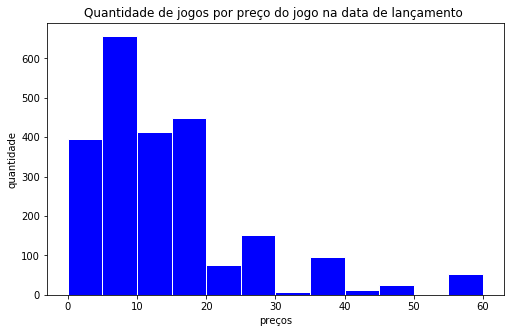

In [54]:
preco_inicial=jogos.OriginalCost

faixas = np.arange(0,65,5)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(preco_inicial, bins=faixas,color='blue', edgecolor='white')
plt.ylabel('quantidade')
plt.xlabel('preços')
plt.title('Quantidade de jogos por preço do jogo na data de lançamento ')

**Quantidade por nota do Metacritic**

Text(0.5, 1.0, 'Quantidade de jogos por nota do Metacritic')

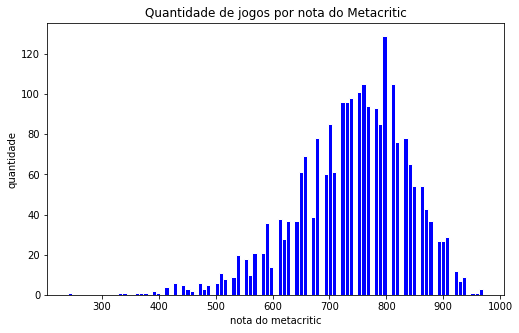

In [55]:
metacritic_inicial=jogos.Metacritic

faixas_metacritic = np.linspace(metacritic_inicial.min(),metacritic_inicial.max(),100)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(metacritic_inicial, bins=faixas_metacritic,color='blue', edgecolor='white')
plt.ylabel('quantidade')
plt.xlabel('nota do metacritic')
plt.title('Quantidade de jogos por nota do Metacritic')

**Nota do Metacritic por preço na data de lançamento, quantidade de achievements, quantidade de citações sobre o jogo na internet e**

Text(0, 0.5, 'nota do metacritic')

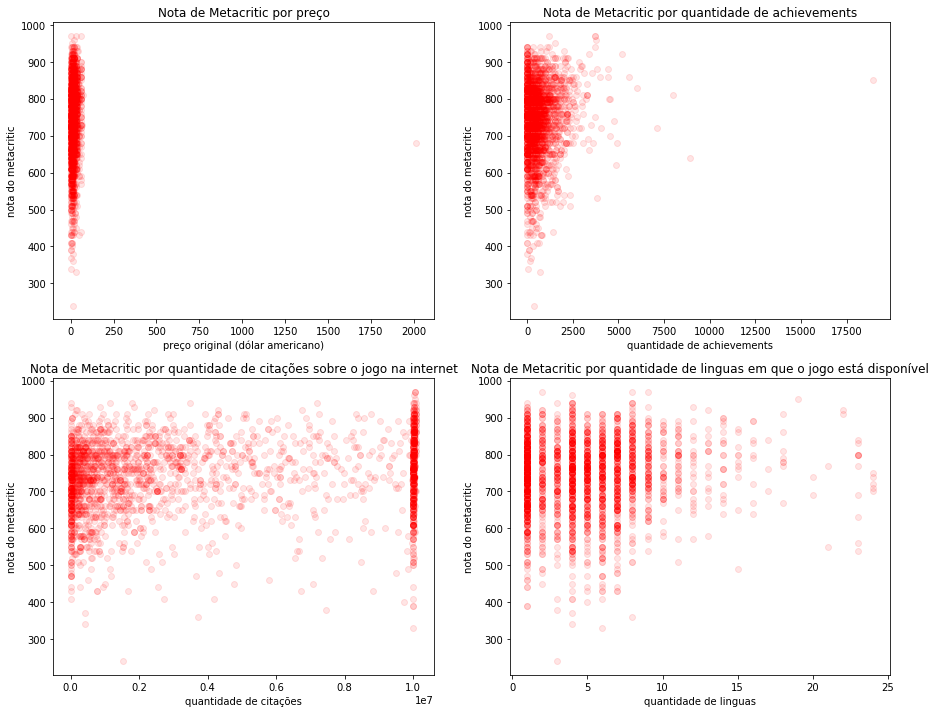

In [56]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.scatter(jogos.OriginalCost,jogos.Metacritic, c='red', alpha=0.1)
plt.title('Nota de Metacritic por preço')
plt.xlabel('preço original (dólar americano)')
plt.ylabel('nota do metacritic')

plt.subplot(222)
plt.scatter(jogos.Achievements,jogos.Metacritic, c='red', alpha=0.1)
plt.title('Nota de Metacritic por quantidade de achievements')
plt.xlabel('quantidade de achievements')
plt.ylabel('nota do metacritic')

plt.subplot(223)
plt.scatter(jogos.Presence,jogos.Metacritic, c='red', alpha=0.1)
plt.title('Nota de Metacritic por quantidade de citações sobre o jogo na internet')
plt.xlabel('quantidade de citações')
plt.ylabel('nota do metacritic')

plt.subplot(224)
plt.scatter(jogos.Languages,jogos.Metacritic, c='red', alpha=0.1)
plt.title('Nota de Metacritic por quantidade de linguas em que o jogo está disponível')
plt.xlabel('quantidade de linguas')
plt.ylabel('nota do metacritic')

In [57]:
jogos = jogos.replace(np.nan, False, regex=True)
jogos.head(5)

Name  Metacritic Indie    Presence  \
0  Counter-Strike: Global Offensive       830.0     0  10095880.0   
1                         Destiny 2       820.0     0  10074250.0   
2          The Elder Scrolls Online       710.0     0  10007810.0   
3                    Sea of Thieves       680.0     0   7774560.0   
4    Tom Clancy's Rainbow Six Siege       750.0     0  10014240.0   

   OriginalCost  Languages  Achievements  Action  Massively Multiplayer  \
0           0.0         23        1790.0    True                  False   
1           0.0          8         610.0    True                  False   
2          19.0          4           0.0   False                   True   
3          39.0          5        3080.0    True                  False   
4          19.0         12         820.0    True                  False   

   Strategy  ...    Wii  PlayStation    Web  Wii U  Game Boy Advance  \
0     False  ...  False         True  False  False             False   
1     False  ...  False         True   True  False             False   
2     False  ...  False        False  False  False             False   
3     False  ...  False        False  False  False             False   
4     False  ...  False         True  False  False             False   

   multiplayer  singleplayer  coop    pvp  online coop  
0         True         False  True   True         True  
1         True         False  True  False         True  
2         True          True  True  False        False  
3         True         False  True   True         True  
4         True          True  True  False         True  

[5 rows x 47 columns]

## Separando o dataframe em treinamento e teste

In [58]:
#separa o dataframe para aplicar a funcao
#faz uma copia do dataframe sem a variavel que queremos prever.
X = jogos.drop('Metacritic',axis=1).drop('Name',axis=1).copy()
#faz uma copia apenas da variavel que vamos prever
y = jogos.Metacritic.copy()
feature_list = list(X.columns)
#separa cada um dos dois dataframes em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)  #o random_state garante que toda vez que o codico \
                                                                            #for rodado, será "a mesma escolha aleatoria"

## Monstrinho

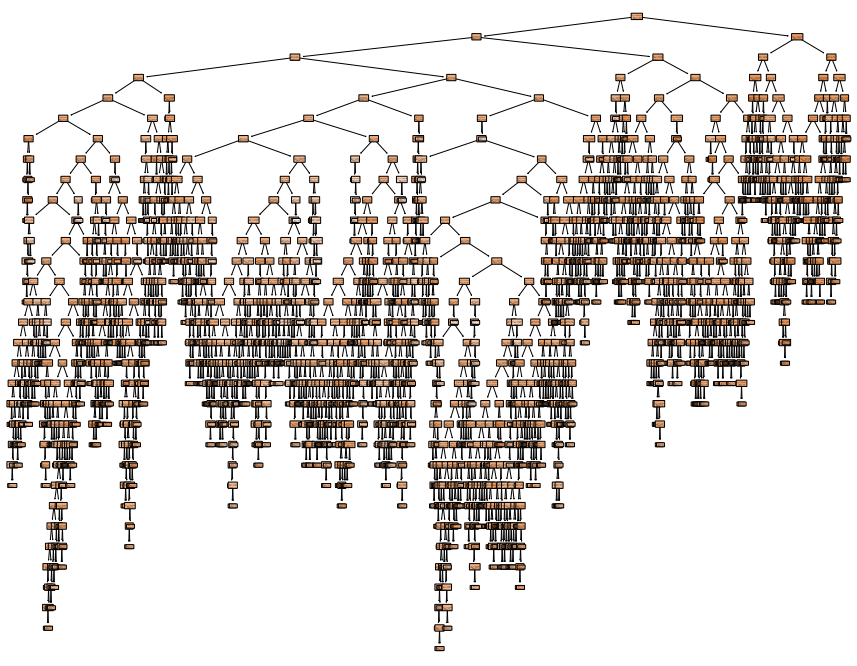

In [59]:
#cria a decision tree regresion a partir dos dados de treinamento
modelo = DecisionTreeRegressor(random_state=2) 
modelo = modelo.fit(X_train, y_train)

#regressor = DecisionTreeRegressor()
#regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

plt.figure(figsize=(15, 12))
plot_tree(modelo, filled=True, rounded=True);

In [60]:
#plot_confusion_matrix(modelo, X_test, y_test)

y_pred = modelo.predict(X_test)


compara = pd.DataFrame({'Real_Values':y_test, 'Predicted_Values':y_pred})
compara

Real_Values  Predicted_Values
2126        780.0             780.0
68          810.0             730.0
606         710.0             830.0
2118        760.0             760.0
344         710.0             780.0
...           ...               ...
1389        720.0             810.0
744         840.0             790.0
1090        810.0             730.0
1902        590.0             680.0
1800        620.0             790.0

[584 rows x 2 columns]

In [61]:
stats = linregress(compara.Real_Values, compara.Predicted_Values)

m = stats.slope
b = stats.intercept


Text(0, 0.5, 'nota do metacritic')

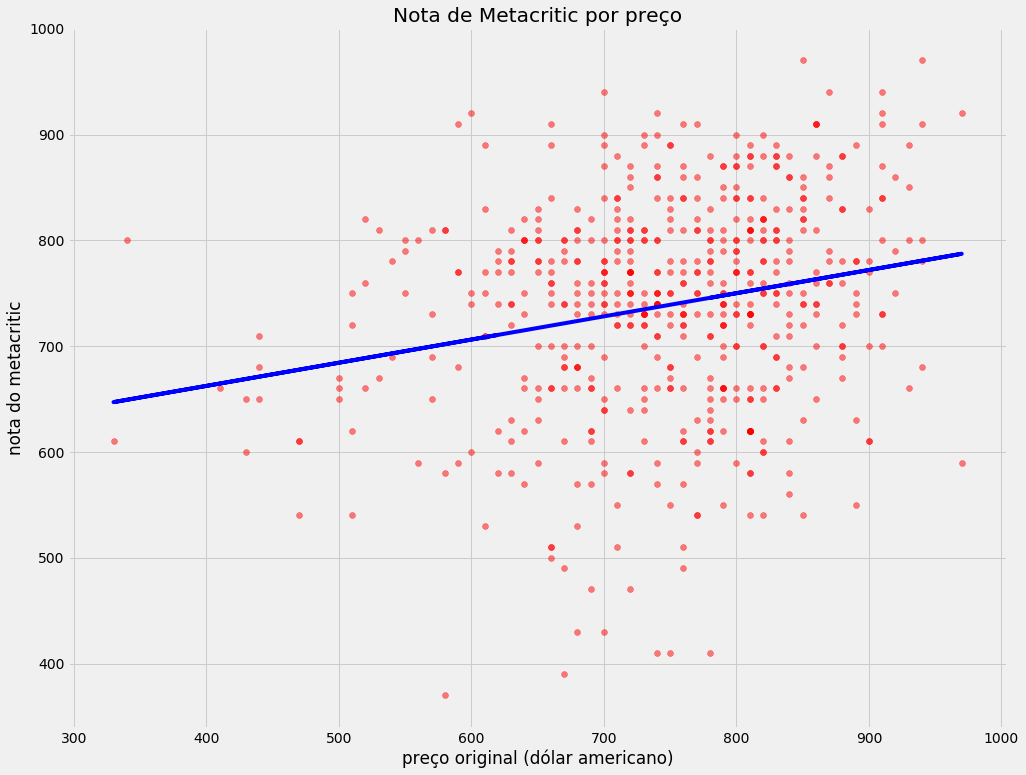

In [106]:
plt.figure(figsize=(15, 12))
plt.plot(compara.Real_Values, m * compara.Real_Values + b, color="blue")
plt.scatter(compara.Real_Values,compara.Predicted_Values,color="red" ,alpha=0.5)
plt.title('Nota de Metacritic por preço')
plt.xlabel('preço original (dólar americano)')
plt.ylabel('nota do metacritic')


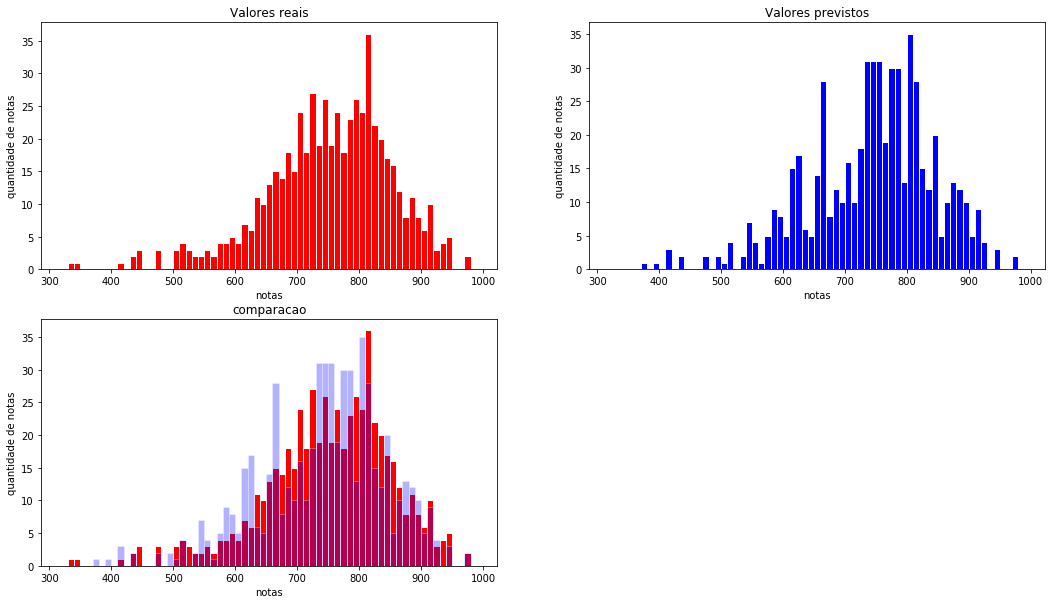

In [63]:
plt.figure(figsize=(18, 10))
faixas= np.arange(320,1000,10)
plt.subplot(221)
plt.title("Valores reais")
plt.ylabel("quantidade de notas")
plt.xlabel("notas")

plt.hist(compara.Real_Values,bins=faixas,color="red" ,edgecolor='white')
plt.subplot(222)
plt.hist(compara.Predicted_Values,bins=faixas,color="blue" ,edgecolor='white')
plt.title("Valores previstos")
plt.ylabel("quantidade de notas")
plt.xlabel("notas")

plt.subplot(223)
plt.title("comparacao")
plt.ylabel("quantidade de notas")
plt.xlabel("notas")
plt.hist(compara.Real_Values,bins=faixas,color="red" ,edgecolor='white')

plt.hist(compara.Predicted_Values,bins=faixas,color="blue" ,edgecolor='white',alpha=0.3)
plt.show()

In [93]:
errors = abs(y_pred - y_test,)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy2 = 100 - np.mean(mape)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Accuracy:', round(accuracy2, 2), '%.')

Mean Absolute Error: 72.11 degrees.
Accuracy: 89.56 %.


In [87]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, random_state=2)

In [88]:


sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test)


In [89]:


regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
regressor.fit(X2_train, y2_train)
y2_pred = regressor.predict(X2_test)

In [91]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, y2_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y2_test, y2_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)))

Mean Absolute Error: 72.1133904109589
Mean Squared Error: 8693.764730136985
Root Mean Squared Error: 93.24035998502464


In [94]:
# Use the forest's predict method on the test data
predictions2 = regressor.predict(X2_test,)
# Calculate the absolute errors
errors2 = abs(predictions2 - y2_test,)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'degrees.')

Mean Absolute Error: 72.11 degrees.


In [95]:
mape2 = 100 * (errors2 / y2_test)
# Calculate and display accuracy
accuracy2 = 100 - np.mean(mape2)
print('Accuracy:', round(accuracy2, 2), '%.')

Accuracy: 89.56 %.


In [96]:


tree = regressor.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file


In [97]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Presence             Importance: 0.29
Variable: Achievements         Importance: 0.13
Variable: OriginalCost         Importance: 0.11
Variable: Languages            Importance: 0.08
Variable: Nintendo Switch      Importance: 0.03
Variable: Indie                Importance: 0.02
Variable: Action               Importance: 0.02
Variable: Strategy             Importance: 0.02
Variable: RPG                  Importance: 0.02
Variable: Simulation           Importance: 0.02
Variable: Adventure            Importance: 0.02
Variable: Linux                Importance: 0.02
Variable: macOS                Importance: 0.02
Variable: multiplayer          Importance: 0.02
Variable: coop                 Importance: 0.02
Variable: Racing               Importance: 0.01
Variable: Casual               Importance: 0.01
Variable: PlayStation 4        Importance: 0.01
Variable: Xbox One             Importance: 0.01
Variable: Android              Importance: 0.01
Variable: iOS                  Importanc

In [76]:

Image(filename='tree.png') 

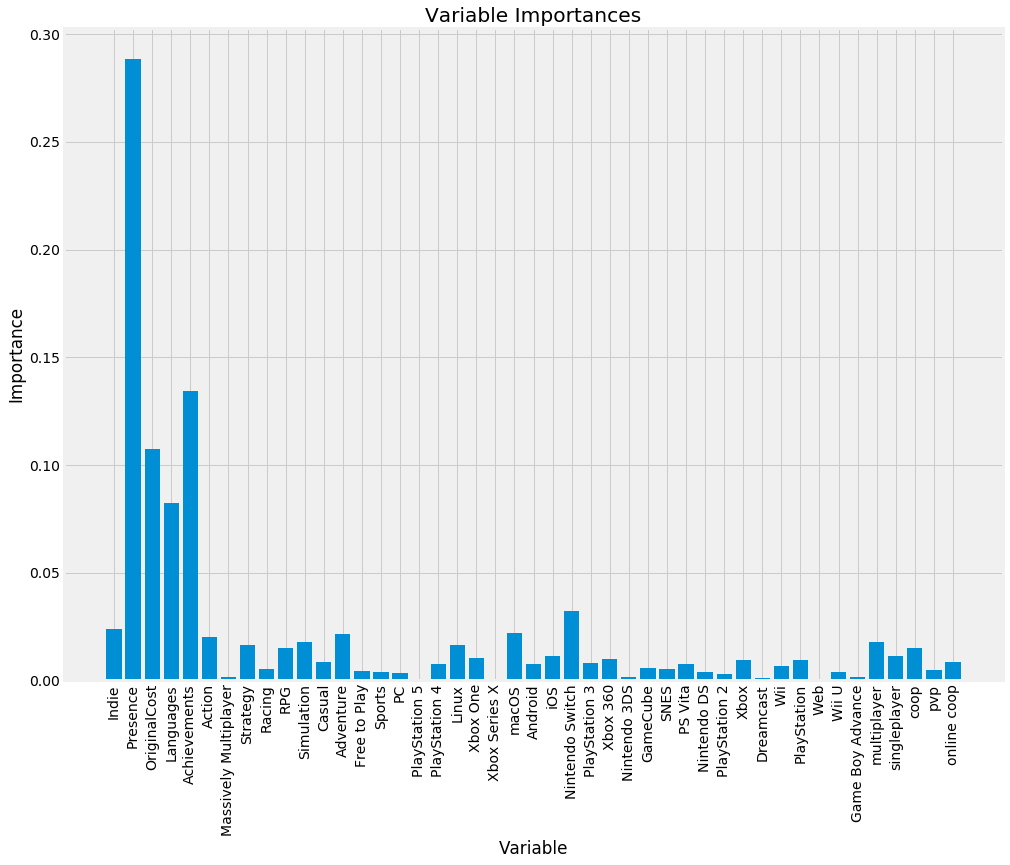

In [98]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
plt.figure(figsize=(15, 12))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x2_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x2_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x2_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

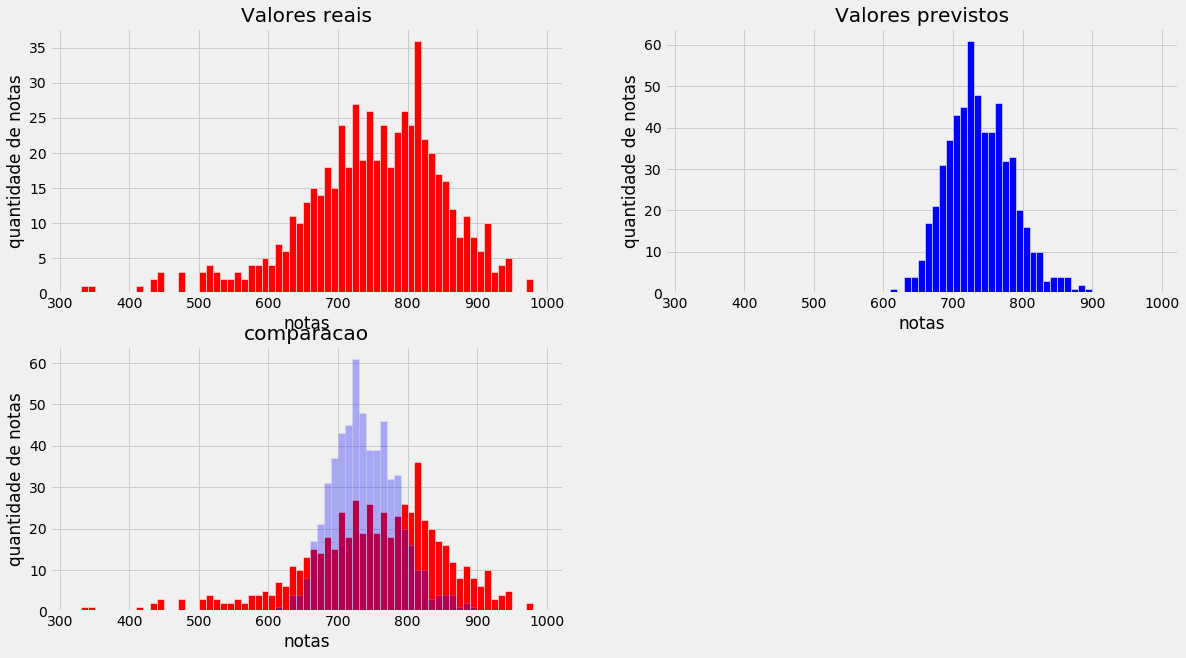

In [102]:
plt.figure(figsize=(18, 10))
faixas= np.arange(320,1000,10)
plt.subplot(221)
plt.title("Valores reais")
plt.ylabel("quantidade de notas")
plt.xlabel("notas")

plt.hist(compara.Real_Values,bins=faixas,color="red" ,edgecolor='white')
plt.subplot(222)
plt.hist(predictions,bins=faixas,color="blue" ,edgecolor='white')
plt.title("Valores previstos")
plt.ylabel("quantidade de notas")
plt.xlabel("notas")

plt.subplot(223)
plt.title("comparacao")
plt.ylabel("quantidade de notas")
plt.xlabel("notas")
plt.hist(compara.Real_Values,bins=faixas,color="red" ,edgecolor='white')

plt.hist(predictions,bins=faixas,color="blue" ,edgecolor='white',alpha=0.3)
plt.show()

In [107]:
stats = linregress(compara.Real_Values, predictions)

m = stats.slope
b = stats.intercept

Text(0, 0.5, 'nota do metacritic')

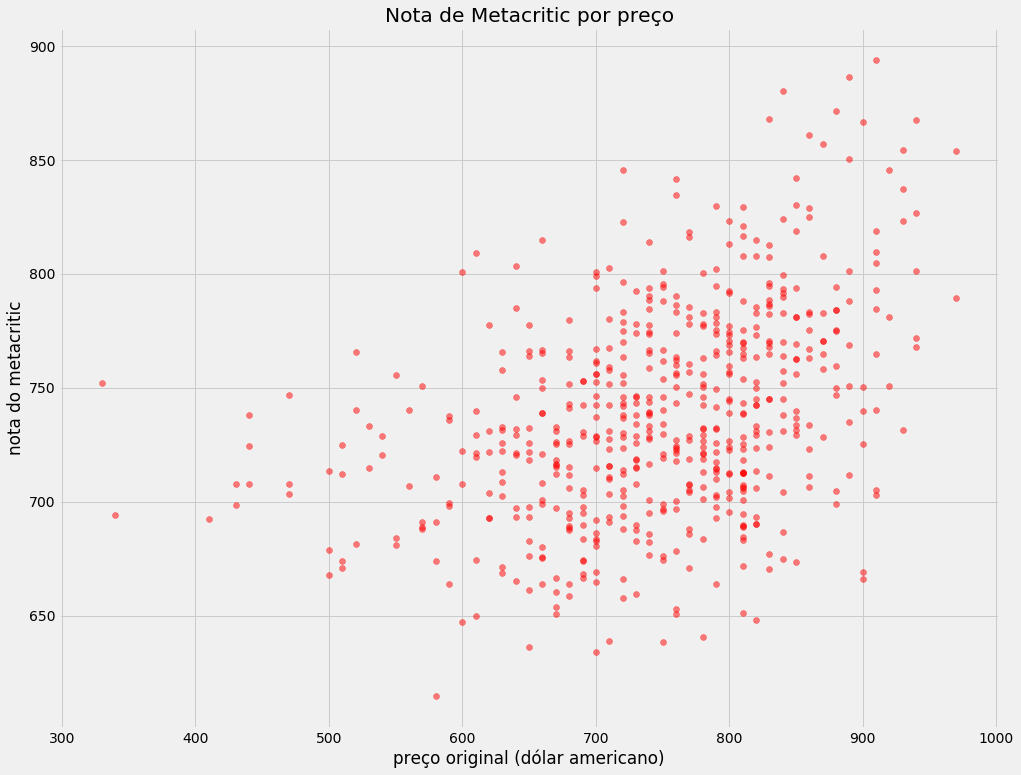

In [108]:
plt.figure(figsize=(15, 12))

plt.scatter(compara.Real_Values,predictions,color="red" ,alpha=0.5)
plt.title('Nota de Metacritic por preço')
plt.xlabel('preço original (dólar americano)')
plt.ylabel('nota do metacritic')

## Referências:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

video maravilindo sobre montar decision tree em python: <br>
https://www.youtube.com/watch?v=q90UDEgYqeI&ab_channel=StatQuestwithJoshStarmer

como implementar uma regresion tree: <br>
https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda

código para a conversõo da coluna "OriginalCost"  <br>
https://stackoverflow.com/questions/48319617/pandas-remove-strings-from-a-float-number-in-a-column

código para a randon forest  <br>
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0